In [1]:
import os
import random
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from tqdm import tqdm

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Import the dataset

In [3]:
processed_dataset_path = '/kaggle/input/liver-fibrosis-us-processed/Liver_Fibrosis_US_processed'

In [4]:
print(os.listdir(processed_dataset_path))

['F1', 'F4', 'F3', 'F2']


In [5]:
classes = os.listdir(processed_dataset_path)
print(classes)

['F1', 'F4', 'F3', 'F2']


## Train DenseNet201 (pretrained on ImageNet)

Test mode only uses 5 images per class for training to allow a quick smoke test. Set to False for full training.

In [6]:
test_mode = False

### Hyperparameters

In [7]:
use_gpu = True  
random_seed = 42

# Hyperparameters 
batch_size = 8 if not test_mode else 8
num_epochs = 30 if not test_mode else 5
learning_rate = 1e-4
num_workers = 4
device = torch.device('cuda' if (use_gpu and torch.cuda.is_available()) else 'cpu')
print('Using device:', device)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Using device: cuda


### Train-Test Split and DataLoaders

In [8]:
to_tensor_only = transforms.Compose([
    transforms.ToTensor(),
])

# Create ImageFolder datasets with no transforms
full_train_dataset = datasets.ImageFolder(processed_dataset_path, transform=to_tensor_only)
full_val_dataset = datasets.ImageFolder(processed_dataset_path, transform=to_tensor_only)

classes = full_train_dataset.classes
num_classes = len(classes)
print('Found classes:', classes)

# Build indices per class
indices_by_class = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(full_train_dataset.samples):
    indices_by_class[label].append(idx)

# For reproducibility shuffle each class list
for k in indices_by_class:
    random.shuffle(indices_by_class[k])

if test_mode:
    # select up to 5 samples per class for training, the rest become validation
    train_indices = []
    val_indices = []
    for k, idxs in indices_by_class.items():
        n_train_per_class = min(5, len(idxs))
        train_chunk = idxs[:n_train_per_class]
        val_chunk = idxs[n_train_per_class:]
        train_indices.extend(train_chunk)
        val_indices.extend(val_chunk)
else:
    # standard 80/20 split across the whole dataset
    n_total = len(full_train_dataset)
    n_train = int(0.8 * n_total)
    all_indices = list(range(n_total))
    random.shuffle(all_indices)
    train_indices = all_indices[:n_train]
    val_indices = all_indices[n_train:]

# Create Subset datasets
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)
print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Found classes: ['F1', 'F2', 'F3', 'F4']
Train samples: 3320, Val samples: 831


### Model Config

In [9]:
# Build model
model = models.densenet201(pretrained=True)

# Replace classifier
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Scheduler optional
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 239MB/s]


In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100. * correct/total)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Eval', leave=False)
        for inputs, targets in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
    epoch_loss = running_loss / total if total>0 else 0
    epoch_acc = correct / total if total>0 else 0
    return epoch_loss, epoch_acc, all_targets, all_preds, all_probs

### Training Loop

In [11]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_wts = None

patience = 5  # Stop if no improvement for 10 epochs

epochs_without_improvement = 0
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping
    if epochs_without_improvement >= patience:
        print(f'Early stopping: no improvement for {patience} epochs')
        break

total_time = time.time() - start_time
print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s. Best val acc: {best_val_acc:.4f}')

Epoch 1/30


Train loss: 0.8563 acc: 0.6244 | Val loss: 0.6746 acc: 0.7184
Epoch 2/30


Train loss: 0.4879 acc: 0.8229 | Val loss: 0.3830 acc: 0.8628
Epoch 3/30


Train loss: 0.2638 acc: 0.9102 | Val loss: 0.9431 acc: 0.7473
Epoch 4/30


Train loss: 0.1375 acc: 0.9584 | Val loss: 0.0903 acc: 0.9759
Epoch 5/30


Train loss: 0.1042 acc: 0.9687 | Val loss: 0.3492 acc: 0.8700
Epoch 6/30


Train loss: 0.0983 acc: 0.9669 | Val loss: 0.0920 acc: 0.9735
Epoch 7/30


Train loss: 0.0848 acc: 0.9741 | Val loss: 0.1122 acc: 0.9603
Epoch 8/30


Train loss: 0.0253 acc: 0.9940 | Val loss: 0.0337 acc: 0.9868
Epoch 9/30


Train loss: 0.0167 acc: 0.9973 | Val loss: 0.0338 acc: 0.9856
Epoch 10/30


Train loss: 0.0118 acc: 0.9988 | Val loss: 0.0319 acc: 0.9892
Epoch 11/30


Train loss: 0.0134 acc: 0.9979 | Val loss: 0.0281 acc: 0.9880
Epoch 12/30


Train loss: 0.0088 acc: 0.9985 | Val loss: 0.0243 acc: 0.9892
Epoch 13/30


Train loss: 0.0051 acc: 1.0000 | Val loss: 0.0278 acc: 0.9892
Epoch 14/30


Train loss: 0.0088 acc: 0.9991 | Val loss: 0.0282 acc: 0.9880
Epoch 15/30


Train loss: 0.0059 acc: 0.9997 | Val loss: 0.0295 acc: 0.9892
Early stopping: no improvement for 5 epochs
Training complete in 45m 56s. Best val acc: 0.9892


### Loading the model

In [12]:
# Load best weights back into model
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

# Evaluate on validation set and collect predictions
val_loss, val_acc, val_targets, val_preds, val_probs = evaluate(model, val_loader, criterion, device)
print(f'Final val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')


Final val loss: 0.0319, val acc: 0.9892


### Plotting Training Curves

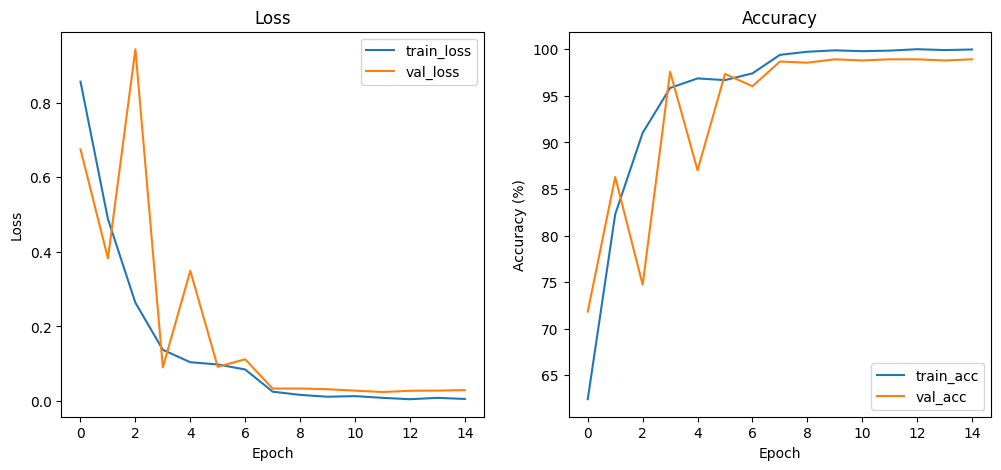

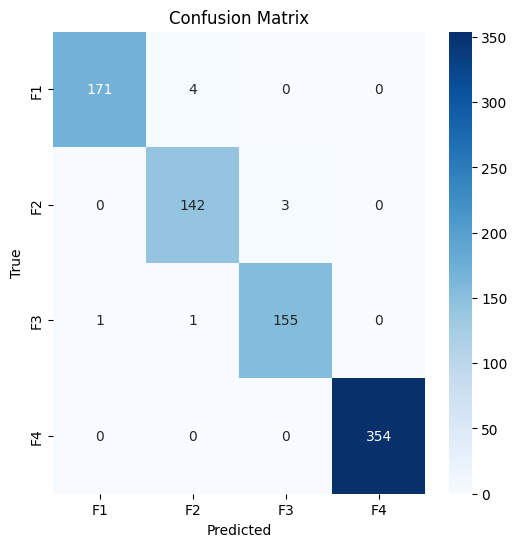


Classification report:
              precision    recall  f1-score   support

          F1       0.99      0.98      0.99       175
          F2       0.97      0.98      0.97       145
          F3       0.98      0.99      0.98       157
          F4       1.00      1.00      1.00       354

    accuracy                           0.99       831
   macro avg       0.99      0.99      0.99       831
weighted avg       0.99      0.99      0.99       831



In [13]:
# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot([x*100 for x in history['train_acc']], label='train_acc')
plt.plot([x*100 for x in history['val_acc']], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')
plt.show()
# Confusion matrix (small datasets may have classes missing in val)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(val_targets, val_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print('\nClassification report:')
    print(classification_report(val_targets, val_preds, target_names=classes, zero_division=0))
except Exception as e:
    print('Could not compute confusion matrix or classification report:', e)


### Exporting the Model

In [14]:
# Export model
out_dir = Path('outputs')
out_dir.mkdir(parents=True, exist_ok=True)

# Save state_dict
torch.save(model.state_dict(), out_dir / 'densenet201_state_dict.pth')

# Save full model (may be large)
torch.save(model, out_dir / 'densenet201_full_model.pt')

print(f'Saved model to {out_dir}')
print(f'  - State dict: {out_dir / "densenet201_state_dict.pth"}')
print(f'  - Full model: {out_dir / "densenet201_full_model.pt"}')

Saved model to outputs
  - State dict: outputs/densenet201_state_dict.pth
  - Full model: outputs/densenet201_full_model.pt
